In [1]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math

In [2]:
import shapefile
import networkx as nx
import geopandas as gpd
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [26]:
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(color='gray')
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            #cm=plt.get_cmap('Paired')
            cm=plt.get_cmap('bone')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [27]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [35]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(color='gray')
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm = plt.get_cmap('bone')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [89]:
df = pd.read_csv("D:/桌面的数据/RUC_class/2_sem1/机器学习/final_project/data/yellowTripdata2020/yellow_tripdata_2020-04.csv")
df.head()

C:\Users\86181\AppData\Local\Temp\ipykernel_60476\2732604411.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("D:/桌面的数据/RUC_class/2_sem1/机器学习/final_project/data/yellowTripdata2020/yellow_tripdata_2020-04.csv")


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-04-01 00:41:22,2020-04-01 01:01:53,1.0,1.20,1.0,N,41,24,2.0,5.5,0.5,0.5,0.00,0.0,0.3,6.80,0.0
1,1.0,2020-04-01 00:56:00,2020-04-01 01:09:25,1.0,3.40,1.0,N,95,197,1.0,12.5,0.5,0.5,2.75,0.0,0.3,16.55,0.0
2,1.0,2020-04-01 00:00:26,2020-04-01 00:09:25,1.0,2.80,1.0,N,237,137,1.0,10.0,3.0,0.5,1.00,0.0,0.3,14.80,2.5
3,1.0,2020-04-01 00:24:38,2020-04-01 00:34:38,0.0,2.60,1.0,N,68,142,1.0,10.0,3.0,0.5,1.00,0.0,0.3,14.80,2.5
4,2.0,2020-04-01 00:13:24,2020-04-01 00:18:26,1.0,1.44,1.0,Y,263,74,1.0,6.5,0.5,0.5,3.00,0.0,0.3,13.30,2.5


In [90]:
str(list(df['tpep_pickup_datetime'])[1])[:10]

'2020-04-01'

In [91]:
f = lambda x:str(x)[:10]
df['pickup_day'] = df['tpep_pickup_datetime'].apply(f)

In [92]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_day
0,1.0,2020-04-01 00:41:22,2020-04-01 01:01:53,1.0,1.20,1.0,N,41,24,2.0,5.5,0.5,0.5,0.00,0.0,0.3,6.80,0.0,2020-04-01
1,1.0,2020-04-01 00:56:00,2020-04-01 01:09:25,1.0,3.40,1.0,N,95,197,1.0,12.5,0.5,0.5,2.75,0.0,0.3,16.55,0.0,2020-04-01
2,1.0,2020-04-01 00:00:26,2020-04-01 00:09:25,1.0,2.80,1.0,N,237,137,1.0,10.0,3.0,0.5,1.00,0.0,0.3,14.80,2.5,2020-04-01
3,1.0,2020-04-01 00:24:38,2020-04-01 00:34:38,0.0,2.60,1.0,N,68,142,1.0,10.0,3.0,0.5,1.00,0.0,0.3,14.80,2.5,2020-04-01
4,2.0,2020-04-01 00:13:24,2020-04-01 00:18:26,1.0,1.44,1.0,Y,263,74,1.0,6.5,0.5,0.5,3.00,0.0,0.3,13.30,2.5,2020-04-01


In [93]:
df = df[df['pickup_day']=='2020-04-12']
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_day
81149,1.0,2020-04-12 00:29:19,2020-04-12 00:31:28,1.0,0.80,1.0,N,143,238,1.0,4.5,3.0,0.5,1.65,0.0,0.3,9.95,2.5,2020-04-12
81150,1.0,2020-04-12 00:07:55,2020-04-12 00:18:44,1.0,1.90,1.0,N,140,230,1.0,9.5,3.0,0.5,3.30,0.0,0.3,16.60,2.5,2020-04-12
81151,1.0,2020-04-12 00:49:50,2020-04-12 00:53:18,1.0,1.10,1.0,N,237,75,1.0,5.5,3.0,0.5,1.00,0.0,0.3,10.30,2.5,2020-04-12
81152,2.0,2020-04-12 00:43:37,2020-04-12 00:55:55,1.0,3.27,1.0,N,152,75,4.0,-11.5,-0.5,-0.5,0.00,0.0,-0.3,-15.30,-2.5,2020-04-12
81153,2.0,2020-04-12 00:43:37,2020-04-12 00:55:55,1.0,3.27,1.0,N,152,75,2.0,11.5,0.5,0.5,0.00,0.0,0.3,15.30,2.5,2020-04-12


In [83]:
df.to_csv("D:/桌面的数据/RUC_class/2_sem1/机器学习/final_project/data/taxi_0804.csv")

In [9]:
len(df)

8450

In [8]:
sf = shapefile.Reader("D:/桌面的数据/RUC_class/2_sem1/机器学习/final_project/data/taxi_zones/taxi_zones.shp")

In [9]:
fields_name = [field[0] for field in sf.fields[1:]]
fields_name

['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough']

In [10]:
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [11]:
df_loc = pd.read_csv('D:/桌面的数据/RUC_class/2_sem1/机器学习/final_project/data/zone_lat_lon.csv')
df_loc.head()

,X,Y,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
0,-74.176786,40.689516,1,0.116357,0.000782,Newark Airport,1,EWR
1,-73.826126,40.625724,2,0.433470,0.004866,Jamaica Bay,2,Queens
2,-73.849479,40.865888,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx
3,-73.977023,40.724152,4,0.043567,0.000112,Alphabet City,4,Manhattan
4,-74.189930,40.550340,5,0.092146,0.000498,Arden Heights,5,Staten Island


In [12]:
df_loc1 = df_loc[['X','Y','LocationID']]
df_loc1.head()

,X,Y,LocationID
0,-74.176786,40.689516,1
1,-73.826126,40.625724,2
2,-73.849479,40.865888,3
3,-73.977023,40.724152,4
4,-74.189930,40.550340,5


In [13]:
DOL_match = df.merge(df_loc1,left_on='DOLocationID',right_on='LocationID')
DOL_match.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_day,X,Y,LocationID
0,1.0,2020-04-01 00:41:22,2020-04-01 01:01:53,1.0,1.20,1.0,N,41,24,2.0,...,0.5,0.00,0.0,0.3,6.80,0.0,2020-04-01,-73.965569,40.802033,24
1,2.0,2020-04-01 03:31:58,2020-04-01 03:38:40,5.0,1.50,1.0,N,238,24,2.0,...,0.5,0.00,0.0,0.3,11.30,2.5,2020-04-01,-73.965569,40.802033,24
2,2.0,2020-04-01 06:57:09,2020-04-01 06:59:48,5.0,0.77,1.0,N,238,24,2.0,...,0.5,0.00,0.0,0.3,5.30,0.0,2020-04-01,-73.965569,40.802033,24
3,1.0,2020-04-01 06:31:29,2020-04-01 06:39:33,1.0,3.20,1.0,N,50,24,2.0,...,0.5,0.00,0.0,0.3,13.80,2.5,2020-04-01,-73.965569,40.802033,24
4,1.0,2020-04-01 08:49:06,2020-04-01 08:56:01,1.0,2.10,1.0,N,142,24,1.0,...,0.5,3.35,0.0,0.3,14.65,2.5,2020-04-01,-73.965569,40.802033,24


In [14]:
DOL_match1 = DOL_match.merge(df_loc1,left_on='PULocationID',right_on='LocationID')
DOL_match1.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,pickup_day,X_x,Y_x,LocationID_x,X_y,Y_y,LocationID_y
0,1.0,2020-04-01 00:41:22,2020-04-01 01:01:53,1.0,1.20,1.0,N,41,24,2.0,...,0.3,6.8,0.0,2020-04-01,-73.965569,40.802033,24,-73.952065,40.804205,41
1,2.0,2020-04-01 16:59:30,2020-04-01 17:09:26,1.0,1.63,1.0,N,41,24,2.0,...,0.3,10.8,0.0,2020-04-01,-73.965569,40.802033,24,-73.952065,40.804205,41
2,2.0,2020-04-01 21:40:52,2020-04-01 21:48:26,1.0,2.78,1.0,N,41,142,1.0,...,0.3,14.8,2.5,2020-04-01,-73.981352,40.773906,142,-73.952065,40.804205,41
3,1.0,2020-04-01 01:19:52,2020-04-01 01:22:51,1.0,0.60,1.0,N,41,74,2.0,...,0.3,5.8,0.0,2020-04-01,-73.938311,40.805566,74,-73.952065,40.804205,41
4,2.0,2020-04-01 08:49:01,2020-04-01 08:56:12,1.0,1.15,1.0,N,41,74,2.0,...,0.3,7.3,0.0,2020-04-01,-73.938311,40.805566,74,-73.952065,40.804205,41


In [35]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.scatter_geo(
        lon = DOL_match['X'],
        lat = DOL_match['Y']
        )

fig.update_layout(
        title = 'Chronic Disease Indicators in US',
        geo_scope='usa',
    )
#fig.savefig('D:/桌面的数据/RUC_class/Sem2/贝叶斯/final_project/data_map.svg')
fig.show()

In [36]:
import plotly.graph_objects as go
fig = go.Figure(go.Densitymapbox(lon = DOL_match['X'],
                                 lat = DOL_match['Y'],
                                 radius=5))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=180)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [47]:
df_loc = df_loc[df_loc['borough']=='Manhattan']

In [48]:
df_loc1 = df_loc[['X','Y','LocationID']]
df_loc1.head()

,X,Y,LocationID
3,-73.977023,40.724152,4
11,-74.015490,40.702488,12
12,-74.016120,40.711612,13
23,-73.965569,40.802033,24
40,-73.952065,40.804205,41


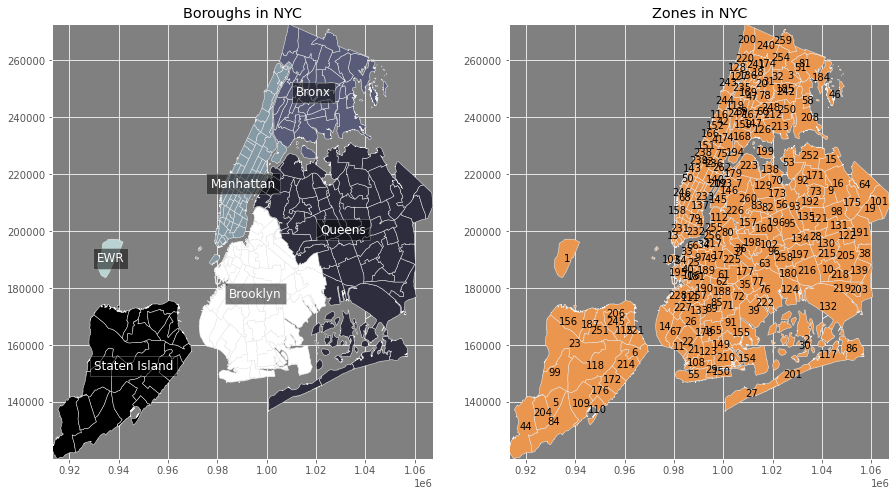

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

fig.savefig('D:/桌面的数据/RUC_class/2_sem1/机器学习/final_project/NYC_zone.svg',format='svg')

In [146]:
df = pd.read_csv("D:/桌面的数据/RUC_class/2_sem1/机器学习/final_project/data/taxi_0625.csv")
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_day
0,374652,2.0,2020-06-25 00:05:29,2020-06-25 00:09:32,1.0,0.94,1.0,N,237,262,4.0,-5.5,-0.5,-0.5,0.0,0.0,-0.3,-9.3,-2.5,2020-06-25
1,374653,2.0,2020-06-25 00:05:29,2020-06-25 00:09:32,1.0,0.94,1.0,N,237,262,2.0,5.5,0.5,0.5,0.0,0.0,0.3,9.3,2.5,2020-06-25
2,374887,1.0,2020-06-25 00:16:25,2020-06-25 00:22:32,1.0,1.80,1.0,N,262,151,2.0,8.0,3.0,0.5,0.0,0.0,0.3,11.8,2.5,2020-06-25
3,374888,2.0,2020-06-25 00:10:28,2020-06-25 00:13:38,1.0,0.70,1.0,N,116,244,2.0,4.5,0.5,0.5,0.0,0.0,0.3,5.8,0.0,2020-06-25
4,374889,2.0,2020-06-25 00:17:53,2020-06-25 00:23:55,1.0,1.13,1.0,N,116,152,2.0,6.5,0.5,0.5,0.0,0.0,0.3,7.8,0.0,2020-06-25


In [18]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_day
0,1.0,2020-04-01 00:41:22,2020-04-01 01:01:53,1.0,1.20,1.0,N,41,24,2.0,5.5,0.5,0.5,0.00,0.0,0.3,6.80,0.0,2020-04-01
1,1.0,2020-04-01 00:56:00,2020-04-01 01:09:25,1.0,3.40,1.0,N,95,197,1.0,12.5,0.5,0.5,2.75,0.0,0.3,16.55,0.0,2020-04-01
2,1.0,2020-04-01 00:00:26,2020-04-01 00:09:25,1.0,2.80,1.0,N,237,137,1.0,10.0,3.0,0.5,1.00,0.0,0.3,14.80,2.5,2020-04-01
3,1.0,2020-04-01 00:24:38,2020-04-01 00:34:38,0.0,2.60,1.0,N,68,142,1.0,10.0,3.0,0.5,1.00,0.0,0.3,14.80,2.5,2020-04-01
4,2.0,2020-04-01 00:13:24,2020-04-01 00:18:26,1.0,1.44,1.0,Y,263,74,1.0,6.5,0.5,0.5,3.00,0.0,0.3,13.30,2.5,2020-04-01


In [24]:
from shapely import wkt

In [19]:
#df_loc1 = gpd.read_file("D:/桌面的数据/RUC_class/2_sem1/机器学习/final_project/data/manhattan_centriod.shp")
df_loc = gpd.read_file("D:/桌面的数据/RUC_class/2_sem1/机器学习/final_project/data/taxi_zones/taxi_zones.shp")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


In [26]:
f = lambda x:x.centroid.wkt

df_loc['centriods'] = df_loc['geometry'].apply(f)
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centriods
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",POINT (935996.8210162065 191376.74953083202)
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",POINT (1031085.7186032843 164018.75440320166)
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",POINT (1026452.6168734727 254265.47865856893)
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",POINT (990633.9806410479 202959.7823911368)
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",POINT (931871.3700680139 140681.35137597343)


In [33]:
f = lambda x:x.split(' ')[1].split('(')[1]

df_loc['X_dest'] = df_loc['centriods'].apply(f)
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centriods,X_dest
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",POINT (935996.8210162065 191376.74953083202),935996.8210162065
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",POINT (1031085.7186032843 164018.75440320166),1031085.7186032843
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",POINT (1026452.6168734727 254265.47865856893),1026452.6168734727
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",POINT (990633.9806410479 202959.7823911368),990633.9806410479
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",POINT (931871.3700680139 140681.35137597343),931871.3700680139


In [34]:
f = lambda x:x.split(' ')[2].split(')')[0]

df_loc['Y_dest'] = df_loc['centriods'].apply(f)
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centriods,X_dest,Y_dest
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",POINT (935996.8210162065 191376.74953083202),935996.8210162065,191376.74953083202
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",POINT (1031085.7186032843 164018.75440320166),1031085.7186032843,164018.75440320166
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",POINT (1026452.6168734727 254265.47865856893),1026452.6168734727,254265.47865856893
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",POINT (990633.9806410479 202959.7823911368),990633.9806410479,202959.7823911368
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",POINT (931871.3700680139 140681.35137597343),931871.3700680139,140681.35137597343


In [35]:
pd.set_option('display.max_rows',None)

In [37]:
f = lambda x:float(x)

df_loc['Y_dest'] = df_loc['Y_dest'].apply(f)
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centriods,X_dest,Y_dest
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",POINT (935996.8210162065 191376.74953083202),935996.8210162065,191376.749531
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",POINT (1031085.7186032843 164018.75440320166),1031085.7186032843,164018.754403
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",POINT (1026452.6168734727 254265.47865856893),1026452.6168734727,254265.478659
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",POINT (990633.9806410479 202959.7823911368),990633.9806410479,202959.782391
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",POINT (931871.3700680139 140681.35137597343),931871.3700680139,140681.351376


In [38]:
f = lambda x:float(x)

df_loc['X_dest'] = df_loc['X_dest'].apply(f)
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centriods,X_dest,Y_dest
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",POINT (935996.8210162065 191376.74953083202),9.359968e+05,191376.749531
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",POINT (1031085.7186032843 164018.75440320166),1.031086e+06,164018.754403
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",POINT (1026452.6168734727 254265.47865856893),1.026453e+06,254265.478659
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",POINT (990633.9806410479 202959.7823911368),9.906340e+05,202959.782391
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",POINT (931871.3700680139 140681.35137597343),9.318714e+05,140681.351376


In [ ]:
#split the 69 zones into 13 region
region_ID =[[12, 13, 87, 88, 209, 231, 261],
           [113, 114, 125, 144, 158, 211, 249],
           [4, 45, 79, 148, 232],
           [48, 50, 68, 90, 246],
           [100, 161, 163, 164, 186, 230, 234],
           [107, 137, 162, 170, 224, 229, 233],
           [24, 142, 143, 151, 238, 239],
           [140, 141, 202, 236, 237, 262, 263],
           [116, 152, 166],
           [41, 42],
           [74, 75, 194],
           [120, 127, 128, 153, 243, 244],
           [43]]

In [149]:


new_loc = pd.DataFrame()
new_df = pd.DataFrame()
for i in range(len(region_ID)):
    loc_sel = df_loc1[df_loc1['LocationID'].isin(region_ID[i])]
    df_sel = df[df['PULocationID'].isin(region_ID[i])]
    df_sel['PURegionID'] = i+1
    loc_sel['RegionID']=i+1
    loc_sel['X_reg']=loc_sel['X_dest'].mean()
    loc_sel['Y_reg']=loc_sel['Y_dest'].mean()
    new_loc = pd.concat([new_loc,loc_sel])
    new_df = pd.concat([new_df,df_sel])

C:\Users\86181\AppData\Local\Temp\ipykernel_119892\461695013.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel['PURegionID'] = i+1
C:\Users\86181\Anaconda3\envs\Rlanguage\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\86181\Anaconda3\envs\Rlanguage\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [150]:
new_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,X_dest,Y_dest,geometry,RegionID,X_reg,Y_reg
1,12,0.036661,0.000042,Battery Park,12,Manhattan,979934.7306,195378.9729,POINT (979934.731 195378.973),1,981270.758957,197487.414514
2,13,0.050281,0.000149,Battery Park City,13,Manhattan,979792.3310,198691.5254,POINT (979792.331 198691.525),1,981270.758957,197487.414514
14,87,0.036902,0.000067,Financial District North,87,Manhattan,982171.7279,196785.9408,POINT (982171.728 196785.941),1,981270.758957,197487.414514
15,88,0.035205,0.000057,Financial District South,88,Manhattan,981057.2643,195528.9248,POINT (981057.264 195528.925),1,981270.758957,197487.414514
49,209,0.030695,0.000039,Seaport,209,Manhattan,983234.0457,197610.8236,POINT (983234.046 197610.824),1,981270.758957,197487.414514


In [151]:
new_df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_day,PURegionID
140,375029,2.0,2020-06-25 00:43:01,2020-06-25 01:13:58,2.0,11.02,1.0,N,231,244,...,34.5,0.5,0.5,7.66,0.0,0.3,45.96,2.5,2020-06-25,1
177,375067,2.0,2020-06-25 00:37:39,2020-06-25 01:03:50,1.0,7.11,1.0,N,87,48,...,25.0,0.5,0.5,5.76,0.0,0.3,34.56,2.5,2020-06-25,1
207,375097,2.0,2020-06-25 00:46:52,2020-06-25 00:57:32,1.0,2.08,1.0,N,261,232,...,9.5,0.5,0.5,0.00,0.0,0.3,13.30,2.5,2020-06-25,1
241,375131,1.0,2020-06-25 01:32:59,2020-06-25 01:55:13,1.0,0.00,1.0,N,88,241,...,38.2,0.0,0.5,0.00,0.0,0.3,39.00,0.0,2020-06-25,1
291,375181,2.0,2020-06-25 01:54:22,2020-06-25 02:15:05,1.0,8.89,1.0,N,231,67,...,26.5,0.5,0.5,0.00,0.0,0.3,30.30,2.5,2020-06-25,1


In [152]:
new_df1 = pd.DataFrame()
for i in range(len(region_ID)):
    df_sel = new_df[new_df['DOLocationID'].isin(region_ID[i])]
    df_sel['DORegionID'] = i+1
    new_df1 = pd.concat([new_df1,df_sel])
new_df1.head()

C:\Users\86181\AppData\Local\Temp\ipykernel_119892\2626355975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel['DORegionID'] = i+1
C:\Users\86181\AppData\Local\Temp\ipykernel_119892\2626355975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel['DORegionID'] = i+1
C:\Users\86181\AppData\Local\Temp\ipykernel_119892\2626355975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_day,PURegionID,DORegionID
874,375766,2.0,2020-06-25 06:59:54,2020-06-25 07:09:22,1.0,1.35,1.0,N,13,231,...,0.0,0.5,0.00,0.0,0.3,10.80,2.5,2020-06-25,1,1
945,375837,2.0,2020-06-25 06:39:31,2020-06-25 06:49:14,1.0,3.51,1.0,N,231,13,...,0.0,0.5,0.00,0.0,0.3,15.80,2.5,2020-06-25,1,1
1197,376089,2.0,2020-06-25 06:36:31,2020-06-25 06:40:55,1.0,1.01,1.0,N,231,231,...,0.0,0.5,0.00,0.0,0.3,8.80,2.5,2020-06-25,1,1
1248,376140,1.0,2020-06-25 06:46:46,2020-06-25 06:54:46,1.0,1.20,1.0,N,13,231,...,2.5,0.5,0.00,0.0,0.3,10.80,2.5,2020-06-25,1,1
2370,377262,2.0,2020-06-25 08:16:13,2020-06-25 08:21:27,1.0,0.64,1.0,N,231,231,...,0.0,0.5,2.49,0.0,0.3,10.79,2.5,2020-06-25,1,1


In [15]:
DOL_match1.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,pickup_day,X_x,Y_x,LocationID_x,X_y,Y_y,LocationID_y
0,1.0,2020-04-01 00:41:22,2020-04-01 01:01:53,1.0,1.20,1.0,N,41,24,2.0,...,0.3,6.8,0.0,2020-04-01,-73.965569,40.802033,24,-73.952065,40.804205,41
1,2.0,2020-04-01 16:59:30,2020-04-01 17:09:26,1.0,1.63,1.0,N,41,24,2.0,...,0.3,10.8,0.0,2020-04-01,-73.965569,40.802033,24,-73.952065,40.804205,41
2,2.0,2020-04-01 21:40:52,2020-04-01 21:48:26,1.0,2.78,1.0,N,41,142,1.0,...,0.3,14.8,2.5,2020-04-01,-73.981352,40.773906,142,-73.952065,40.804205,41
3,1.0,2020-04-01 01:19:52,2020-04-01 01:22:51,1.0,0.60,1.0,N,41,74,2.0,...,0.3,5.8,0.0,2020-04-01,-73.938311,40.805566,74,-73.952065,40.804205,41
4,2.0,2020-04-01 08:49:01,2020-04-01 08:56:12,1.0,1.15,1.0,N,41,74,2.0,...,0.3,7.3,0.0,2020-04-01,-73.938311,40.805566,74,-73.952065,40.804205,41


In [153]:
mx = new_loc['X_reg'].values
my = new_loc['Y_reg'].values
pos = {}
for count, elem in enumerate(new_loc['RegionID']):
     pos[elem] = (mx[count], my[count])

In [154]:
new_loc1 = new_loc[['RegionID','X_reg','Y_reg']]

In [155]:
sel_loc = list(new_loc1['RegionID'])
df1 = new_df1[new_df1['PURegionID'].isin(sel_loc)]
df2 = df1[df1['DORegionID'].isin(sel_loc)]
df2.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_day,PURegionID,DORegionID
874,375766,2.0,2020-06-25 06:59:54,2020-06-25 07:09:22,1.0,1.35,1.0,N,13,231,...,0.0,0.5,0.00,0.0,0.3,10.80,2.5,2020-06-25,1,1
945,375837,2.0,2020-06-25 06:39:31,2020-06-25 06:49:14,1.0,3.51,1.0,N,231,13,...,0.0,0.5,0.00,0.0,0.3,15.80,2.5,2020-06-25,1,1
1197,376089,2.0,2020-06-25 06:36:31,2020-06-25 06:40:55,1.0,1.01,1.0,N,231,231,...,0.0,0.5,0.00,0.0,0.3,8.80,2.5,2020-06-25,1,1
1248,376140,1.0,2020-06-25 06:46:46,2020-06-25 06:54:46,1.0,1.20,1.0,N,13,231,...,2.5,0.5,0.00,0.0,0.3,10.80,2.5,2020-06-25,1,1
2370,377262,2.0,2020-06-25 08:16:13,2020-06-25 08:21:27,1.0,0.64,1.0,N,231,231,...,0.0,0.5,2.49,0.0,0.3,10.79,2.5,2020-06-25,1,1


In [156]:
df21 = df2.merge(new_loc1,left_on='PURegionID',right_on='RegionID',how='inner')
df22 = df21.merge(new_loc1,left_on='DORegionID',right_on='RegionID',how='inner')
df22.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,congestion_surcharge,pickup_day,PURegionID,DORegionID,RegionID_x,X_reg_x,Y_reg_x,RegionID_y,X_reg_y,Y_reg_y
0,375766,2.0,2020-06-25 06:59:54,2020-06-25 07:09:22,1.0,1.35,1.0,N,13,231,...,2.5,2020-06-25,1,1,1,981270.758957,197487.414514,1,981270.758957,197487.414514
1,375766,2.0,2020-06-25 06:59:54,2020-06-25 07:09:22,1.0,1.35,1.0,N,13,231,...,2.5,2020-06-25,1,1,1,981270.758957,197487.414514,1,981270.758957,197487.414514
2,375766,2.0,2020-06-25 06:59:54,2020-06-25 07:09:22,1.0,1.35,1.0,N,13,231,...,2.5,2020-06-25,1,1,1,981270.758957,197487.414514,1,981270.758957,197487.414514
3,375766,2.0,2020-06-25 06:59:54,2020-06-25 07:09:22,1.0,1.35,1.0,N,13,231,...,2.5,2020-06-25,1,1,1,981270.758957,197487.414514,1,981270.758957,197487.414514
4,375766,2.0,2020-06-25 06:59:54,2020-06-25 07:09:22,1.0,1.35,1.0,N,13,231,...,2.5,2020-06-25,1,1,1,981270.758957,197487.414514,1,981270.758957,197487.414514


In [40]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_day
0,1.0,2020-04-01 00:41:22,2020-04-01 01:01:53,1.0,1.20,1.0,N,41,24,2.0,5.5,0.5,0.5,0.00,0.0,0.3,6.80,0.0,2020-04-01
1,1.0,2020-04-01 00:56:00,2020-04-01 01:09:25,1.0,3.40,1.0,N,95,197,1.0,12.5,0.5,0.5,2.75,0.0,0.3,16.55,0.0,2020-04-01
2,1.0,2020-04-01 00:00:26,2020-04-01 00:09:25,1.0,2.80,1.0,N,237,137,1.0,10.0,3.0,0.5,1.00,0.0,0.3,14.80,2.5,2020-04-01
3,1.0,2020-04-01 00:24:38,2020-04-01 00:34:38,0.0,2.60,1.0,N,68,142,1.0,10.0,3.0,0.5,1.00,0.0,0.3,14.80,2.5,2020-04-01
4,2.0,2020-04-01 00:13:24,2020-04-01 00:18:26,1.0,1.44,1.0,Y,263,74,1.0,6.5,0.5,0.5,3.00,0.0,0.3,13.30,2.5,2020-04-01


In [41]:
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centriods,X_dest,Y_dest
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",POINT (935996.8210162065 191376.74953083202),9.359968e+05,191376.749531
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",POINT (1031085.7186032843 164018.75440320166),1.031086e+06,164018.754403
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",POINT (1026452.6168734727 254265.47865856893),1.026453e+06,254265.478659
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",POINT (990633.9806410479 202959.7823911368),9.906340e+05,202959.782391
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",POINT (931871.3700680139 140681.35137597343),9.318714e+05,140681.351376


In [42]:
df_loc1 = df_loc[['LocationID','X_dest','Y_dest']]

In [94]:
df1 = df.merge(df_loc1,left_on='PULocationID',right_on='LocationID')
df1.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_day,LocationID,X_dest,Y_dest
0,1.0,2020-04-12 00:29:19,2020-04-12 00:31:28,1.0,0.80,1.0,N,143,238,1.0,...,0.5,1.65,0.0,0.3,9.95,2.5,2020-04-12,143,987671.709701,221982.085493
1,2.0,2020-04-12 05:39:55,2020-04-12 05:49:07,1.0,2.95,1.0,N,143,75,1.0,...,0.5,0.00,0.0,0.3,14.30,2.5,2020-04-12,143,987671.709701,221982.085493
2,1.0,2020-04-12 05:59:08,2020-04-12 06:11:46,1.0,5.70,1.0,N,143,244,1.0,...,0.5,5.45,0.0,0.3,27.25,2.5,2020-04-12,143,987671.709701,221982.085493
3,2.0,2020-04-12 06:44:51,2020-04-12 06:50:48,1.0,1.28,1.0,N,143,238,2.0,...,0.5,0.00,0.0,0.3,9.30,2.5,2020-04-12,143,987671.709701,221982.085493
4,1.0,2020-04-12 06:19:00,2020-04-12 06:29:36,1.0,5.30,1.0,N,143,244,1.0,...,0.5,3.95,0.0,0.3,23.75,2.5,2020-04-12,143,987671.709701,221982.085493


In [95]:
df2 = df1.merge(df_loc1,left_on='DOLocationID',right_on='LocationID')
df2.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,pickup_day,LocationID_x,X_dest_x,Y_dest_x,LocationID_y,X_dest_y,Y_dest_y
0,1.0,2020-04-12 00:29:19,2020-04-12 00:31:28,1.0,0.80,1.0,N,143,238,1.0,...,0.3,9.95,2.5,2020-04-12,143,987671.709701,221982.085493,238,991712.764441,227717.518059
1,2.0,2020-04-12 06:44:51,2020-04-12 06:50:48,1.0,1.28,1.0,N,143,238,2.0,...,0.3,9.30,2.5,2020-04-12,143,987671.709701,221982.085493,238,991712.764441,227717.518059
2,1.0,2020-04-12 09:27:50,2020-04-12 09:33:15,1.0,1.10,1.0,N,143,238,1.0,...,0.3,10.30,2.5,2020-04-12,143,987671.709701,221982.085493,238,991712.764441,227717.518059
3,1.0,2020-04-12 13:18:26,2020-04-12 13:27:20,1.0,1.90,1.0,N,143,238,1.0,...,0.3,14.15,2.5,2020-04-12,143,987671.709701,221982.085493,238,991712.764441,227717.518059
4,2.0,2020-04-12 13:53:36,2020-04-12 13:59:46,1.0,1.35,1.0,N,143,238,1.0,...,0.3,12.88,2.5,2020-04-12,143,987671.709701,221982.085493,238,991712.764441,227717.518059


In [96]:
len(df2)

4371

In [97]:
df22 = df2[df2['PULocationID']!=df2['DOLocationID']]

In [98]:
len(df22)

4042

In [99]:
graph = nx.from_pandas_edgelist(df22, source = 'PULocationID', target = 'DOLocationID',create_using = nx.DiGraph())

In [100]:
edges = graph.edges()
edges

OutEdgeView([(143, 238), (143, 75), (143, 244), (143, 247), (143, 140), (143, 141), (143, 151), (143, 85), (143, 239), (143, 50), (143, 142), (143, 164), (143, 186), (143, 161), (143, 48), (143, 163), (143, 236), (143, 249), (143, 116), (143, 43), (143, 74), (143, 137), (143, 78), (143, 257), (143, 237), (238, 75), (238, 244), (238, 140), (238, 141), (238, 151), (238, 239), (238, 50), (238, 142), (238, 186), (238, 161), (238, 143), (238, 48), (238, 236), (238, 249), (238, 116), (238, 74), (238, 137), (238, 237), (238, 230), (238, 7), (238, 263), (238, 229), (238, 25), (238, 159), (238, 233), (238, 107), (238, 170), (238, 68), (238, 168), (238, 42), (238, 41), (238, 79), (238, 166), (238, 234), (238, 4), (238, 181), (238, 246), (238, 24), (238, 243), (238, 152), (238, 174), (238, 132), (238, 167), (238, 169), (238, 60), (238, 241), (140, 238), (140, 75), (140, 244), (140, 141), (140, 151), (140, 239), (140, 142), (140, 186), (140, 143), (140, 48), (140, 163), (140, 236), (140, 116), (14

In [101]:
weights = []
for u,v in edges:
    sel_df = df22[(df22['PULocationID']==u)& (df22['DOLocationID']==v)]
    weights.append(sel_df['passenger_count'].mean())

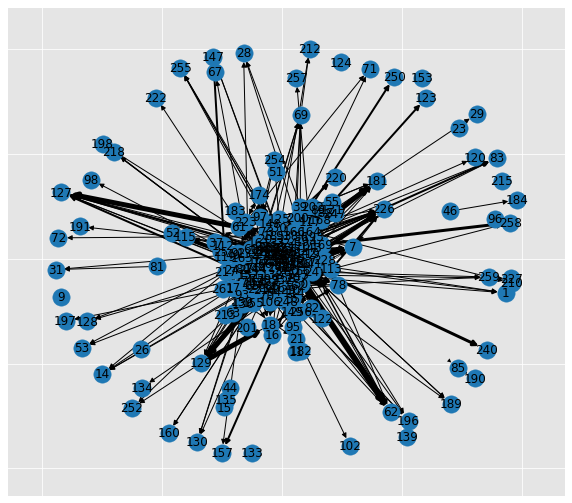

In [102]:
plt.figure(figsize = (10,9))
nx.draw_networkx(graph,width=weights)
#plt.savefig("./images/map_0.png", format = "png", dpi = 300)
plt.show()

In [55]:
sf = gpd.read_file("D:/桌面的数据/RUC_class/2_sem1/机器学习/final_project/data/taxi_zones/taxi_zones.shp")
sf.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


In [76]:
df22.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,pickup_day,LocationID_x,X_dest_x,Y_dest_x,LocationID_y,X_dest_y,Y_dest_y
0,1.0,2020-04-01 00:41:22,2020-04-01 01:01:53,1.0,1.20,1.0,N,41,24,2.0,...,0.3,6.80,0.0,2020-04-01,41,997734.645233,232321.290548,24,993807.271658,231458.376056
1,2.0,2020-04-01 16:59:30,2020-04-01 17:09:26,1.0,1.63,1.0,N,41,24,2.0,...,0.3,10.80,0.0,2020-04-01,41,997734.645233,232321.290548,24,993807.271658,231458.376056
2,2.0,2020-04-01 10:27:14,2020-04-01 10:44:23,1.0,4.60,1.0,N,68,24,2.0,...,0.3,19.80,2.5,2020-04-01,68,984272.778633,211948.912400,24,993807.271658,231458.376056
3,1.0,2020-04-01 12:43:07,2020-04-01 12:47:29,1.0,1.30,1.0,N,75,24,1.0,...,0.3,8.16,0.0,2020-04-01,75,999272.111383,227103.759625,24,993807.271658,231458.376056
4,1.0,2020-04-01 13:58:39,2020-04-01 14:10:16,1.0,1.60,1.0,N,75,24,3.0,...,0.3,10.30,0.0,2020-04-01,75,999272.111383,227103.759625,24,993807.271658,231458.376056


In [72]:
from collections import Counter

d = Counter(df2['DOLocationID'])
count = pd.DataFrame.from_dict(d, orient='index').reset_index()
count.head()

,index,0
0,24,57
1,43,100
2,42,168
3,74,295
4,48,261


In [73]:
count = count.rename(columns={'index':'LocationID', 0:'total_rider'})

In [74]:
count.head()

,LocationID,total_rider
0,24,57
1,43,100
2,42,168
3,74,295
4,48,261


In [75]:
len(count)

225

In [59]:
rider = []
for i in graph.nodes():
    rider.append(list(count[count['LocationID']==i]['total_rider'])[0])
rider

IndexError: list index out of range

In [67]:
#cmap='bone'

DiDegreeView({41: 82, 24: 51, 68: 87, 75: 122, 141: 105, 137: 174, 140: 141, 48: 110, 238: 105, 143: 71, 186: 105, 90: 92, 239: 91, 230: 92, 151: 78, 166: 65, 164: 83, 50: 74, 170: 115, 142: 92, 152: 42, 162: 101, 43: 71, 211: 33, 237: 108, 263: 112, 229: 87, 249: 77, 236: 98, 161: 81, 107: 113, 234: 88, 74: 113, 100: 90, 163: 86, 244: 62, 262: 78, 231: 67, 113: 72, 42: 70, 168: 35, 116: 36, 213: 23, 232: 37, 247: 24, 167: 19, 119: 9, 233: 88, 79: 85, 7: 48, 182: 22, 87: 58, 69: 24, 144: 42, 138: 47, 71: 10, 174: 15, 195: 8, 17: 19, 210: 10, 92: 12, 259: 8, 132: 92, 145: 19, 193: 16, 136: 24, 246: 46, 112: 17, 126: 15, 127: 19, 243: 29, 60: 9, 45: 23, 248: 7, 54: 6, 114: 35, 226: 35, 261: 33, 146: 30, 125: 41, 188: 33, 88: 35, 134: 9, 108: 3, 148: 44, 169: 18, 194: 5, 39: 22, 223: 20, 235: 23, 47: 21, 19: 3, 158: 28, 25: 19, 95: 22, 159: 23, 260: 22, 224: 40, 38: 7, 205: 15, 3: 5, 203: 4, 4: 35, 76: 33, 123: 5, 242: 12, 13: 38, 61: 25, 62: 10, 65: 29, 190: 3, 209: 26, 22: 6, 179: 16, 5

In [64]:
mx = df_loc['X_dest'].values
my = df_loc['Y_dest'].values
pos = {}
for count, elem in enumerate(df_loc['LocationID']):
     pos[elem] = (mx[count], my[count])

In [104]:
d = dict(graph.degree)

C:\Users\86181\Anaconda3\envs\Rlanguage\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


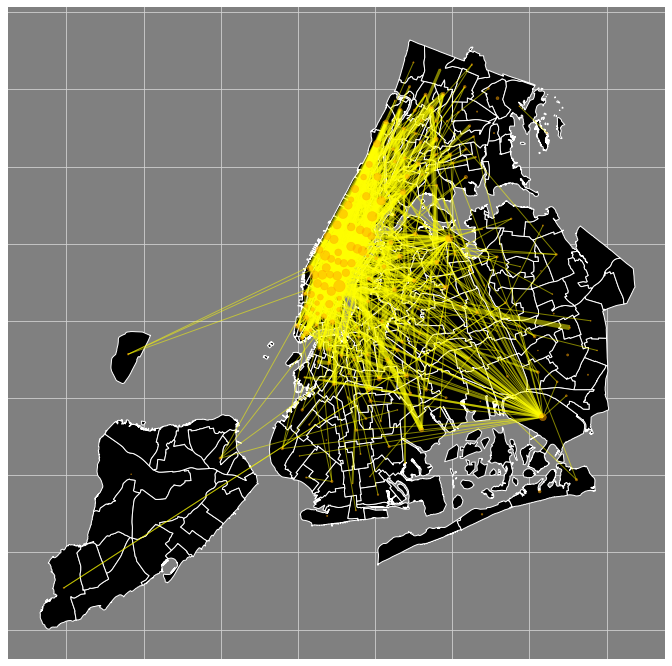

In [106]:
ax = sf.plot(column='borough', color='black',edgecolors='white',linewidth=1,legend=False, figsize = (12,12))
    
    
nx.draw_networkx_nodes(G = graph, pos = pos, node_color = 'orange', alpha = 0.5,
                       node_size=[v * 1 for v in d.values()])
                       #node_size=[i*0.005 for i in rider])

nx.draw_networkx_edges(G = graph, pos = pos, edge_color='yellow',
                       connectionstyle=f"arc3,rad={0.2}",
                        width=weights, alpha=0.5, arrows = False)
ax.set_facecolor('gray')
ax.grid(color='lightgray')
plt.savefig('D:/桌面的数据/RUC_class/2_sem2/advanced_applied_statistics/project1/final/real_0412.svg',format='svg')